1. 네이버 영화리뷰 감정 분석 코퍼스에 SentencePiece를 적용시킨 모델 학습하기
2. 학습된 모델로 sp_tokenize() 메소드 구현하기
3. 구현된 토크나이저를 적용하여 네이버 영화리뷰 감정 분석 모델을 재학습하기  
4. KoNLPy 형태소 분석기를 사용한 모델과 성능 비교하기
5. SentencePiece 모델의 model_type, vocab_size 등을 변경해 가면서 성능 개선 여부 확인하기

# 1. 라이브러리 및 데이터 로드

In [ ]:
!pip install konlpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 129.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 495.9/495.9 kB 41.5 MB/s eta 0:00:00


In [ ]:
import torch
from torch.nn.utils.rnn import pad_sequence
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import konlpy

print(torch.__version__)
print(np.__version__)
print(pd.__version__)
print(matplotlib.__version__)
print(konlpy.__version__)

2.8.0+cu126
2.0.2
2.2.2
3.10.0
0.6.0


In [ ]:
# 네이버 영화리뷰 감정분석 데이터
!wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt
!wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt

--2025-11-13 14:19:59--  https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14628807 (14M) [text/plain]
Saving to: ‘ratings_train.txt’

ratings_train.txt   100%[===================>]  13.95M  --.-KB/s    in 0.07s   

2025-11-13 14:19:59 (209 MB/s) - ‘ratings_train.txt’ saved [14628807/14628807]

--2025-11-13 14:19:59--  https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4893335 (4.7M) [application/octet-

In [ ]:
train = pd.read_table("/content/ratings_train.txt")
test = pd.read_table("/content/ratings_test.txt")

print(train.info())
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        150000 non-null  int64 
 1   document  149995 non-null  object
 2   label     150000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.4+ MB
None


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


# 2. 전처리

In [ ]:
import re

# 불용어 리스트
STOPWORDS = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

# 맞춤법 변형 사전
SPELLING_DICT = {
    '굳': ['궅', '굳', '굿'],
    '미쳤': ['미첫', '미쳣', '미첬', '미쳤', 'ㅁㅊ'],
    '괜찮': ['괜찮', '괜춘', '괜찬', 'ㄱㅊ', '갠찬', '갠찮', '괸찬', '괸찮'],
    '봤': ['봣'],
    '겠': ['겟']
}

# 텍스트 컬럼명
TEXT_COL = "document"

def preprocess_text(text):
    """
    텍스트 전처리 함수
    """
    if pd.isna(text):
        return ""

    text = str(text)

    # 1. 반복되는 문장 부호 제거 (2개 이상 → 1개)
    text = re.sub(r'([.!?…;])\1+', r'\1', text)

    # 2. 맞춤법 변형 통일
    for correct, variations in SPELLING_DICT.items():
        for variant in variations:
            text = text.replace(variant, correct)

    # 3. 반복 문자 제거 (3번 이상 반복 → 2번)
    text = re.sub(r'(.)\1{2,}', r'\1\1', text)

    # 4. 자음/모음 단독 제거 (완성형 한글 필터링 전에 먼저 제거)
    # 한글 자음: ㄱ-ㅎ, 한글 모음: ㅏ-ㅣ
    text = re.sub(r'[ㄱ-ㅎㅏ-ㅣ]+', ' ', text)

    # 5. 영어/숫자/한글/문장부호만 남기고 모두 삭제
    # 이모지, 이모티콘, 특수문자 자동 제거
    text = re.sub(r'[^가-힣a-zA-Z0-9\s.!?,]', ' ', text)

    # 6. 문장부호 앞뒤로 공백 추가
    text = re.sub(r'([.!?,])', r' \1 ', text)

    # 7. 영어 소문자 변환
    text = text.lower()

    # 9. 불용어 제거 (조사가 붙은 경우도 처리)
    words = text.split()

    # 단어 끝에 불용어가 붙어있으면 제거
    filtered_words = []
    for word in words:
        # 단어 전체가 불용어인 경우
        if word in STOPWORDS:
            continue
        # 단어 끝에서 불용어 제거 (가장 긴 것부터 체크)
        # 예: "학교에서" -> "학교", "영화는" -> "영화"
        found = False
        for stopword in sorted(STOPWORDS, key=len, reverse=True):
            if len(word) > len(stopword) and word.endswith(stopword):
                cleaned = word[:-len(stopword)]
                # 남은 부분이 2글자 이상일 때만 제거
                # 굳이 -> 굳, 같이 -> 같  이렇게 바뀌어서 길이 제한 추가했습니다.
                # "굳이" -> "굳" (X), "영화는" -> "영화" (O)
                if len(cleaned) >= 2:
                    filtered_words.append(cleaned)
                    found = True
                    break
        if not found:
            filtered_words.append(word)

    text = ' '.join(filtered_words)

    # 10. 연속 공백을 하나의 공백으로 교체
    text = re.sub(r'\s+', ' ', text)

    # 11. 앞뒤 공백 제거
    text = text.strip()

    return text


def preprocess_dataframe(df, text_col=TEXT_COL):
    """
    데이터프레임 전처리 함수
    """
    print(f"전처리 전 데이터 크기: {len(df)}")

    # 1. 결측치 제거
    df = df.dropna(subset=[text_col])
    print(f"결측치 제거 후: {len(df)}")

    # 2. 텍스트 전처리 적용
    df[text_col] = df[text_col].apply(preprocess_text)

    # 3. 전처리 후 빈 문자열 제거
    df = df[df[text_col].str.strip() != '']
    print(f"빈 문자열 제거 후: {len(df)}")

    # 4. 중복 행 제거
    df = df.drop_duplicates(subset=[text_col])
    print(f"중복 제거 후: {len(df)}")

    # 인덱스 재설정
    df = df.reset_index(drop=True)

    return df


# 샘플 텍스트로 테스트
sample_texts = [
    "어제 본 영화 진짜 재밌었음!!! 또 보고 싶어 😂",
    "나는 오늘 아침에 학교에 갔다. 근데 너무 졸렸음ㅋㅋㅋㅋ",
    "밥은 먹었니?? 아직이야... 점심에 같이 먹자!!!",
    "메캅 형태소 분석은 한국어 처리에서 많이 사용돼 👍",
    "파이썬으로 토큰 빈도와 품사 분포를 시각화해 보자!!!",
    "요즘 코사인 유사도 기반 벡터 검색으로 RG 구축을 많이 해!!",
    "에이전트는 외부 도구를 호출해 작업을 자동화할 수 있어. 굳!",
    "이 영화 진짜 미쳣다!!! 너무 재밌음ㅋㅋㅋㅋ",
    "배우 연기 굳이 훌륭했음, 스토리는 봣지만...",
    "이건 ㄱㅊ 영화네, 굿굿!"
]

print("=" * 80)
print("샘플 텍스트 전처리 결과")
print("=" * 80)
for i, text in enumerate(sample_texts, 1):
    processed = preprocess_text(text)
    print(f"\n[{i}] 원본: {text}")
    print(f"    결과: {processed}")

print("\n" + "=" * 80)
print("실제 데이터 적용 예시")
print("=" * 80)

train_processed = preprocess_dataframe(train.copy())
test_processed = preprocess_dataframe(test.copy())

print("\n전처리 완료!")
print(f"Train 데이터: {len(train_processed)}개")
print(f"Test 데이터: {len(test_processed)}개")

print("\n전처리 결과 샘플:")
print(train_processed.head(10))

샘플 텍스트 전처리 결과

[1] 원본: 어제 본 영화 진짜 재밌었음!!! 또 보고 싶어 😂
    결과: 어제 본 영화 진짜 재밌었음 ! 또 보고 싶어

[2] 원본: 나는 오늘 아침에 학교에 갔다. 근데 너무 졸렸음ㅋㅋㅋㅋ
    결과: 나는 오늘 아침 학교 갔다 . 근데 너무 졸렸음

[3] 원본: 밥은 먹었니?? 아직이야... 점심에 같이 먹자!!!
    결과: 밥은 먹었니 ? 아직이야 . 점심 같이 먹자 !

[4] 원본: 메캅 형태소 분석은 한국어 처리에서 많이 사용돼 👍
    결과: 메캅 형태소 분석 한국어 처리에서 많이 사용돼

[5] 원본: 파이썬으로 토큰 빈도와 품사 분포를 시각화해 보자!!!
    결과: 파이썬 토큰 빈도 품사 분포 시각화해 보자 !

[6] 원본: 요즘 코사인 유사도 기반 벡터 검색으로 RG 구축을 많이 해!!
    결과: 요즘 코사인 유사 기반 벡터 검색 rg 구축을 많이 해 !

[7] 원본: 에이전트는 외부 도구를 호출해 작업을 자동화할 수 있어. 굳!
    결과: 에이전트 외부 도구 호출해 작업을 자동화할 수 있어 . 굳 !

[8] 원본: 이 영화 진짜 미쳣다!!! 너무 재밌음ㅋㅋㅋㅋ
    결과: 영화 진짜 미쳤다 ! 너무 재밌음

[9] 원본: 배우 연기 굳이 훌륭했음, 스토리는 봣지만...
    결과: 배우 연기 굳이 훌륭했음 , 스토리 봤지만 .

[10] 원본: 이건 ㄱㅊ 영화네, 굿굿!
    결과: 이건 괜찮 영화네 , 굳굳 !

실제 데이터 적용 예시
전처리 전 데이터 크기: 150000
결측치 제거 후: 149995
빈 문자열 제거 후: 149607
중복 제거 후: 144478
전처리 전 데이터 크기: 50000
결측치 제거 후: 49997
빈 문자열 제거 후: 49843
중복 제거 후: 48700

전처리 완료!
Train 데이터: 144478개
Test 데이터: 48700개

전처리 결과 샘플:
         id                                       

# 3. 토큰화 (SentencePiece)

In [ ]:
!pip install sentencepiece

## 3.1. SentencePiece 모델 학습

In [ ]:
import sentencepiece as spm
import os

# 학습용 corpus 파일 생성
corpus_file = 'naver_reviews.train.temp'

with open(corpus_file, 'w', encoding='utf-8') as f:
    for text in train_processed['document']:
        f.write(text + '\n')

# SentencePiece 학습
vocab_size = 8000
model_prefix = 'naver_spm'

spm.SentencePieceTrainer.Train(
    f'--input={corpus_file} '
    f'--model_prefix={model_prefix} '
    f'--vocab_size={vocab_size} '
    f'--model_type=bpe '
    f'--pad_id=0 --unk_id=1 --bos_id=2 --eos_id=3 '
    f'--pad_piece=<PAD> --unk_piece=<UNK> --bos_piece=<BOS> --eos_piece=<EOS>'
)

!ls -l naver_spm*

-rw-r--r-- 1 root root 374858 Nov 13 14:20 naver_spm.model
-rw-r--r-- 1 root root 117611 Nov 13 14:20 naver_spm.vocab


In [ ]:
# 학습된 SentencePiece 모델 활용 예시
sp = spm.SentencePieceProcessor(model_file=f'{model_prefix}.model')

sample_text = "이 영화 진짜 미쳣다!!! 너무 재밌음ㅋㅋㅋㅋ"
encoded_ids = sp.encode(preprocess_text(sample_text),  # 샘플 text 전처리
                        out_type=int, add_bos=True, add_eos=True)
decoded_text = sp.decode(encoded_ids)

print("Encoded IDs:", encoded_ids)
print("Decoded Text:", decoded_text)


Encoded IDs: [2, 6, 52, 2756, 6458, 13, 26, 1137, 3]
Decoded Text: 영화 진짜 미쳤다 ! 너무 재밌음


## 3.2. 텐서로 변환
아래 함수는 SentencePiece로 토큰화된 데이터를 LSTM 등 모델 입력용 tensor로 만드는 함수.  
<br>

1. 매개변수로 토큰화된 문장의 list를 전달하는 대신 온전한 문장의 list 를 전달합니다.

2. 생성된 vocab 파일을 읽어와 { \<word> : \<idx> } 형태를 가지는 word_index 사전과 { \<idx> : \<word>} 형태를 가지는 index_word 사전을 생성하고 함께 반환합니다.

3. 리턴값인 tensor 토큰화한 후 Encoding된 문장입니다. 바로 학습에 사용할 수 있게 Padding은 당연히 해야겠죠?


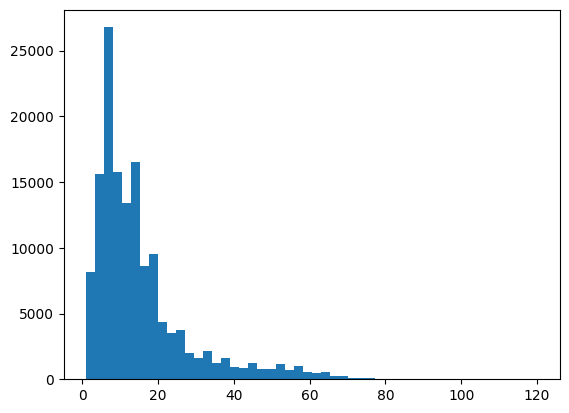

In [ ]:
# max length 지정
import matplotlib.pyplot as plt

lens = [len(sp.EncodeAsIds(sen)) for sen in train_processed['document']]
plt.hist(lens, bins=50)
plt.show()

In [ ]:
import numpy as np
max_len = int(np.percentile(lens, 95))
print(max_len)

46


In [ ]:
def sp_tokenize(s, corpus, max_len=46):
    tensor = []

    # 1. 문장별 토큰화 + 최대 길이 제한
    for sen in corpus:
        ids = sp.EncodeAsIds(sen)     # 토큰화
        ids = ids[:max_len]          # 최대 길이 자르기
        tensor.append(torch.tensor(ids, dtype=torch.long))  # 텐서 변환

    #  2. vocab 파일 불러오기
    with open("./naver_spm.vocab", 'r') as f:
        vocab = f.readlines()

    # 3. 단어 인덱스 매핑
    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]
        word_index[word] = idx
        index_word[idx] = word

    # 4. PAD 토큰(0)으로 패딩
    tensor = pad_sequence(tensor, batch_first=True, padding_value=0)

    return tensor, word_index, index_word

# 4. 데이터 로더

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, random_split

def create_dataloaders(train_tensor, train_labels, test_tensor, test_labels,
                       batch_size=32, val_ratio=0.2):
    dataset = TensorDataset(train_tensor, train_labels)
    val_size = int(len(dataset) * val_ratio)
    train_size = len(dataset) - val_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    test_dataset = TensorDataset(test_tensor, test_labels)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

In [ ]:
import torch
import sentencepiece as spm

# 1. SentencePiece 모델 로드
sp = spm.SentencePieceProcessor(model_file='naver_spm.model')

# 2. 데이터 준비

# 훈련 데이터
corpus_train = train_processed['document'].tolist()
labels_train = torch.tensor(train_processed['label'].values, dtype=torch.long)

# 테스트 데이터
corpus_test = test_processed['document'].tolist()
labels_test = torch.tensor(test_processed['label'].values, dtype=torch.long)

# 4. SentencePiece 토큰화 + 최대 길이 자르기 + 패딩
tensor_train, word_index, index_word = sp_tokenize(sp, corpus_train, max_len=46)
tensor_test, word_index_test, index_word_test = sp_tokenize(sp, corpus_test, max_len=46)

# 5. DataLoader 생성
train_loader, val_loader, test_loader = create_dataloaders(
    train_tensor=tensor_train,
    train_labels=labels_train,
    test_tensor=tensor_test,
    test_labels=labels_test,
    batch_size=32,
    val_ratio=0.2
)

# 6. 데이터 로더 상태 확인
print(f"Train batches: {len(train_loader)}, Validation batches: {len(val_loader)}, Test batches: {len(test_loader)}")

# 학습 데이터 확인
for batch in train_loader:
    x, y = batch
    print("[Train Loader]")
    print("입력 텐서 shape:", x.shape)
    print("레이블 shape:", y.shape)
    break

# 검증 데이터 확인
for batch in val_loader:
    x, y = batch
    print("\n[Validation Loader]")
    print("입력 텐서 shape:", x.shape)
    print("레이블 shape:", y.shape)
    break

# 테스트 데이터 확인
for batch in test_loader:
    if len(batch) == 2:  # test에 label이 있는 경우
        x, y = batch
        print("\n[Test Loader]")
        print("입력 텐서 shape:", x.shape)
        print("레이블 shape:", y.shape)
    else:  # test에 label이 없는 경우
        x = batch[0]
        print("\n[Test Loader]")
        print("입력 텐서 shape:", x.shape)
    break

Train batches: 3612, Validation batches: 903, Test batches: 1522
[Train Loader]
입력 텐서 shape: torch.Size([32, 46])
레이블 shape: torch.Size([32])

[Validation Loader]
입력 텐서 shape: torch.Size([32, 46])
레이블 shape: torch.Size([32])

[Test Loader]
입력 텐서 shape: torch.Size([32, 46])
레이블 shape: torch.Size([32])


# 5. 모델 정의 및 학습

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# 공통 하이퍼파라미터 정의
VOCAB_SIZE = 8000                  # 단어 사전의 크기
EMBEDDING_DIM = 100                # 임베딩 벡터의 차원
HIDDEN_DIM = 128                   # LSTM의 은닉 상태 차원
OUTPUT_DIM = 1                     # 출력 차원 (긍정=1, 부정=0 -> 1개)
N_LAYERS = 2                       # LSTM 레이어 개수
BIDIRECTIONAL = True               # 양방향 RNN/LSTM 여부
DROPOUT_RATE = 0.2                 # 드롭아웃 비율
PAD_IDX = 0                        # 패딩 인덱스 (0)

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers,
                 bidirectional, dropout, pad_idx):
        super().__init__()

        # 1. 임베딩 레이어
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)

        # 2. LSTM 레이어
        self.lstm = nn.LSTM(input_size=embedding_dim,
                           hidden_size=hidden_dim,
                           num_layers=n_layers,
                           bidirectional=bidirectional,
                           batch_first=True,
                           dropout=dropout)

        # 3. FC 레이어
        fc_input_dim = hidden_dim * 2
        self.fc = nn.Linear(fc_input_dim, output_dim)

        # 4. 배치정규화 (LSTM 출력 차원에 맞게)
        fc_input_dim = hidden_dim * 2 if bidirectional else hidden_dim
        self.batchnorm = nn.BatchNorm1d(fc_input_dim)

        # 5. 드롭아웃
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):

        embedded = self.embedding(text)

        # 2. LSTM
        _output, (hidden, cell) = self.lstm(embedded)

        # 3. 양방향인 경우 마지막 forward/backward hidden 연결
        if self.lstm.bidirectional:
            hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        else:
            hidden = hidden[-1,:,:]

        # 4. 드롭아웃
        hidden = self.dropout(hidden)

        # 5. 배치 정규화 (배치 차원 B, feature 차원 F → BatchNorm1d(F) 적용)
        hidden = self.batchnorm(hidden)

        # 6. FC 통과
        output = self.fc(hidden)

        return output.squeeze(1)

In [ ]:
import torch
import torch.optim as optim
import time

# 0. GPU 장치 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# 1. 헬퍼 함수 정의
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def binary_accuracy(preds, y):
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float()
    acc = correct.sum() / len(correct)
    return acc

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

# 2. 훈련 함수 정의
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.train()
    for texts, labels in iterator:
        texts = texts.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        predictions = model(texts)
        loss = criterion(predictions, labels.float())
        acc = binary_accuracy(predictions, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # 클리핑
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

# 3. 평가 함수 정의
def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    with torch.no_grad():
        for texts, labels in iterator:
            texts = texts.to(device)
            labels = labels.to(device)
            predictions = model(texts)
            loss = criterion(predictions, labels.float())
            acc = binary_accuracy(predictions, labels)
            epoch_loss += loss.item()
            epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

Using device: cuda


In [ ]:
# 모델 설정
lstm_model = LSTMModel(
    VOCAB_SIZE,
    EMBEDDING_DIM,
    HIDDEN_DIM,
    OUTPUT_DIM,
    N_LAYERS,
    BIDIRECTIONAL,
    DROPOUT_RATE,
    PAD_IDX
).to(device)

save_path = 'best_model_lstm.pt'
N_EPOCHS = 20
patience = 5
criterion = nn.BCEWithLogitsLoss().to(device)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, lstm_model.parameters()), lr=0.0001)

# Early stopping 변수
best_valid_loss = float('inf')
patience_counter = 0

train_losses, train_accs, valid_losses, valid_accs = [], [], [], []

print(f"\n{'='*60}")
print(f"--- LSTM Model Training starts ---")
print(f"{'='*60}\n")

# 학습 루프
for epoch in range(N_EPOCHS):
    start_time = time.time()

    train_loss, train_acc = train(lstm_model, train_loader, optimizer, criterion)
    valid_loss, valid_acc = evaluate(lstm_model, val_loader, criterion)

    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

    # 기록
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)

    # Early Stopping
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(lstm_model.state_dict(), save_path)
        patience_counter = 0
        print(f'\t>> Validation loss improved ({best_valid_loss:.3f}). Model saved.')
    else:
        patience_counter += 1
        print(f'\t>> Validation loss did not improve. Counter: {patience_counter}/{patience}')
        if patience_counter >= patience:
            print(f'--- Early stopping triggered after {epoch+1} epochs ---')
            break

# 테스트 평가
print(f"\n--- Loading best LSTM model for test evaluation ---")
lstm_model.load_state_dict(torch.load(save_path))
test_loss, test_acc = evaluate(lstm_model, test_loader, criterion)

print(f"\n--- LSTM Model Test Results (Best Model) ---")
print(f'\tTest Loss: {test_loss:.3f}')
print(f'\tTest Acc:  {test_acc*100:.2f}%')



--- LSTM Model Training starts ---

Epoch: 01 | Time: 0m 21s
	Train Loss: 0.593 | Train Acc: 67.16%
	 Val. Loss: 0.488 |  Val. Acc: 76.16%
	>> Validation loss improved (0.488). Model saved.
Epoch: 02 | Time: 0m 21s
	Train Loss: 0.453 | Train Acc: 78.77%
	 Val. Loss: 0.444 |  Val. Acc: 79.26%
	>> Validation loss improved (0.444). Model saved.
Epoch: 03 | Time: 0m 21s
	Train Loss: 0.400 | Train Acc: 82.03%
	 Val. Loss: 0.415 |  Val. Acc: 81.02%
	>> Validation loss improved (0.415). Model saved.
Epoch: 04 | Time: 0m 20s
	Train Loss: 0.365 | Train Acc: 84.06%
	 Val. Loss: 0.416 |  Val. Acc: 81.50%
	>> Validation loss did not improve. Counter: 1/5
Epoch: 05 | Time: 0m 21s
	Train Loss: 0.342 | Train Acc: 85.34%
	 Val. Loss: 0.388 |  Val. Acc: 82.47%
	>> Validation loss improved (0.388). Model saved.
Epoch: 06 | Time: 0m 21s
	Train Loss: 0.322 | Train Acc: 86.49%
	 Val. Loss: 0.385 |  Val. Acc: 83.06%
	>> Validation loss improved (0.385). Model saved.
Epoch: 07 | Time: 0m 20s
	Train Loss: 0.

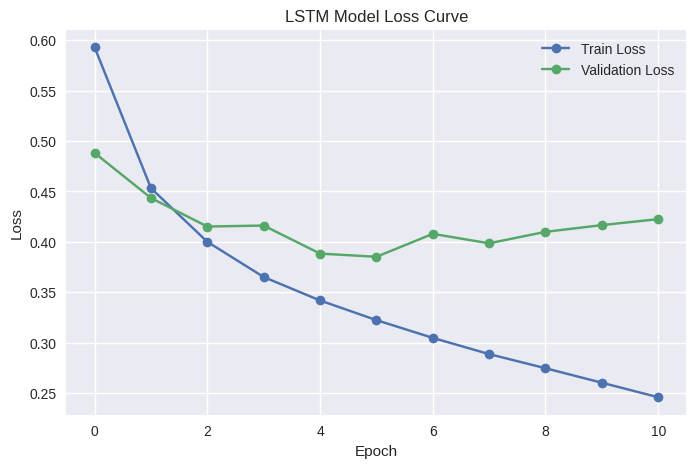

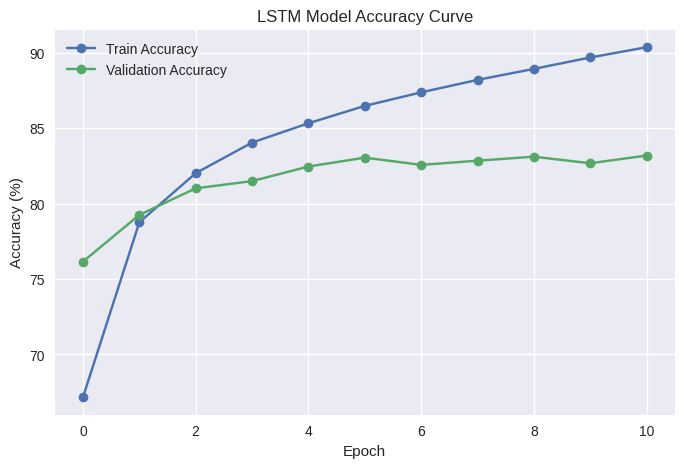

In [ ]:
import matplotlib.pyplot as plt

# 그래프 스타일 설정
plt.style.use('seaborn-v0_8')

# Loss 곡선
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(valid_losses, label='Validation Loss', marker='o')
plt.title('LSTM Model Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Accuracy 곡선
plt.figure(figsize=(8, 5))
plt.plot([acc * 100 for acc in train_accs], label='Train Accuracy', marker='o')
plt.plot([acc * 100 for acc in valid_accs], label='Validation Accuracy', marker='o')
plt.title('LSTM Model Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()

# 6. 다른 토크나이저와 비교

In [ ]:
!pip install konlpy
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab/
!bash install_mecab-ko_on_colab_light_220429.sh

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 138, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 138 (delta 26), reused 22 (delta 8), pack-reused 91 (from 1)
Receiving objects: 100% (138/138), 1.72 MiB | 5.67 MiB/s, done.
Resolving deltas: 100% (65/65), done.
/content/Mecab-ko-for-Google-Colab
Installing konlpy.....
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2025-11-13 15:21:39--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 104.192.142.25, 104.192.142.26, 104.192.142.24, ...
Connecting to bitbucket.org (bitbucket.org)|104.192.142.25|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://bbuseruploads.s3.amazonaws.com/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz?response-content-dispositi

In [ ]:
!sudo apt update
!sudo apt install default-jre

Hit:1 https://cli.github.com/packages stable InRelease
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,130 kB]
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:10 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [9,451 kB]
Hit:11 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:12 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [5,982 kB]
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates/restrict

In [ ]:
print(f"전처리 완료한 Train 데이터: {len(train_processed)}개")
print(f"전처리 완료한 Test 데이터: {len(test_processed)}개")

print("\n전처리 결과 샘플:")
print(train_processed.head(10))

전처리 완료한 Train 데이터: 144478개
전처리 완료한 Test 데이터: 48700개

전처리 결과 샘플:
         id                                           document  label
0   9976970                                아 더빙 . 진짜 짜증나네요 목소리      0
1   3819312                   흠 . 포스터보고 초딩영화줄 . 오버연기조차 가볍지 않구나      1
2  10265843                                  너무재밓었다그래서보는것을추천한다      0
3   9045019                      교도소 이야기구먼 . 솔직히 재미 없다 . 평점 조정      0
4   6483659  사이몬페그 익살스런 연기 돋보였던 영화 ! 스파이더맨에서 늙어보이기만 했던 커스틴 ...      1
5   5403919        막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화 . . 별반개 아까움 .      0
6   7797314                              원작 긴장감을 제대로 살려내지못했다 .      0
7   9443947  별 반개 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지 . 정말 발로해 그것보단 ...      0
8   7156791                                액션 없는데 재미 있는 몇안되 영화      1
9   5912145     왜케 평점 낮은건데 ? 꽤 볼만한데 . 헐리우드식 화려함에만 너무 길들여져 있나 ?      1


In [ ]:
# KoNLPy용 토큰화 및 텐서 변환 함수
def konlpy_build_vocab(corpus, tokenizer, vocab_size=8000):
    """KoNLPy 토크나이저로 말뭉치에서 사전을 구축합니다."""
    print("사전 구축 시작...")
    counter = Counter()
    for text in corpus:
        tokens = tokenizer.morphs(text)
        counter.update(tokens)

    # SentencePiece와 동일하게 8000개로 제한 (특수 토큰 4개 포함)
    common_words = counter.most_common(vocab_size - 4)

    word_index = {'<PAD>': 0, '<UNK>': 1, '<BOS>': 2, '<EOS>': 3}
    for i, (word, _) in enumerate(common_words):
        word_index[word] = i + 4

    index_word = {i: w for w, i in word_index.items()}
    print(f"사전 구축 완료. 총 단어 수: {len(word_index)}")
    return word_index, index_word

def konlpy_texts_to_tensors(corpus, tokenizer, word_index, max_len=46):
    """KoNLPy로 토큰화된 텍스트 리스트를 텐서로 변환합니다."""
    tensor = []
    for text in corpus:
        tokens = tokenizer.morphs(text)
        ids = [word_index.get(t, word_index['<UNK>']) for t in tokens]
        ids = ids[:max_len] # 최대 길이 제한
        tensor.append(torch.tensor(ids, dtype=torch.long))

    # 패딩
    tensor = pad_sequence(tensor, batch_first=True, padding_value=word_index['<PAD>'])
    return tensor

# 학습 및 평가 전체 파이프라인
def run_experiment(tokenizer_name, tokenizer, train_corpus, test_corpus,
                   train_labels, test_labels, common_hparams):

    print(f"\n{'='*60}")
    print(f"--- {tokenizer_name} 모델 실험 시작 ---")
    print(f"{'='*60}")

    # 1. 사전 구축
    word_index, index_word = konlpy_build_vocab(train_corpus, tokenizer, vocab_size=common_hparams['VOCAB_SIZE'])

    # 2. 텐서 변환
    print("텐서 변환 시작...")
    tensor_train = konlpy_texts_to_tensors(train_corpus, tokenizer, word_index, max_len=common_hparams['MAX_LEN'])
    tensor_test = konlpy_texts_to_tensors(test_corpus, tokenizer, word_index, max_len=common_hparams['MAX_LEN'])
    print("텐서 변환 완료.")

    # 3. 데이터 로더 생성
    train_loader, val_loader, test_loader = create_dataloaders(
        tensor_train, train_labels,
        tensor_test, test_labels,
        batch_size=common_hparams['BATCH_SIZE'],
        val_ratio=0.2
    )
    print(f"데이터 로더 생성 완료. Train: {len(train_loader)}, Val: {len(val_loader)}, Test: {len(test_loader)}")

    # 4. 모델 초기화
    # *** 중요: vocab_size를 SentencePiece의 8000개가 아닌, 실제 구축된 사전 크기로 설정 ***
    actual_vocab_size = len(word_index)

    model = LSTMModel(
        vocab_size=actual_vocab_size,
        embedding_dim=common_hparams['EMBEDDING_DIM'],
        hidden_dim=common_hparams['HIDDEN_DIM'],
        output_dim=common_hparams['OUTPUT_DIM'],
        n_layers=common_hparams['N_LAYERS'],
        bidirectional=common_hparams['BIDIRECTIONAL'],
        dropout=common_hparams['DROPOUT_RATE'],
        pad_idx=common_hparams['PAD_IDX']
    ).to(device)

    save_path = f'best_model_{tokenizer_name.lower()}.pt'
    criterion = nn.BCEWithLogitsLoss().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.0001) # SP와 동일한 LR

    # 5. 학습 루프
    best_valid_loss = float('inf')
    patience_counter = 0
    history = {'train_loss': [], 'train_acc': [], 'valid_loss': [], 'valid_acc': []}

    print("\n--- 모델 학습 시작 ---")
    for epoch in range(common_hparams['N_EPOCHS']):
        start_time = time.time()

        train_loss, train_acc = train(model, train_loader, optimizer, criterion)
        valid_loss, valid_acc = evaluate(model, val_loader, criterion)

        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['valid_loss'].append(valid_loss)
        history['valid_acc'].append(valid_acc)

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), save_path)
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= common_hparams['PATIENCE']:
                print(f'--- Early stopping triggered after {epoch+1} epochs ---')
                break

    # 6. 테스트 평가
    print(f"\n--- {tokenizer_name} 모델 테스트 평가 ---")
    model.load_state_dict(torch.load(save_path))
    test_loss, test_acc = evaluate(model, test_loader, criterion)

    print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

    return test_loss, test_acc, history

# 그래프 그리기 함수
def plot_history(history, title):
    plt.style.use('seaborn-v0_8')
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

    # Loss
    ax1.plot(history['train_loss'], label='Train Loss', marker='o')
    ax1.plot(history['valid_loss'], label='Validation Loss', marker='o')
    ax1.set_title(f'{title} - Loss Curve')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    # Accuracy
    ax2.plot([acc * 100 for acc in history['train_acc']], label='Train Accuracy', marker='o')
    ax2.plot([acc * 100 for acc in history['valid_acc']], label='Validation Accuracy', marker='o')
    ax2.set_title(f'{title} - Accuracy Curve')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True)

    plt.show()

In [ ]:
# --- 공통 하이퍼파라미터 및 데이터 준비 ---

# SentencePiece 모델과 동일한 하이퍼파라미터 사용
common_hparams = {
    'VOCAB_SIZE': 8000,          # KoNLPy에서는 이 크기를 "최대" 크기로 사용
    'EMBEDDING_DIM': 100,
    'HIDDEN_DIM': 128,
    'OUTPUT_DIM': 1,
    'N_LAYERS': 2,
    'BIDIRECTIONAL': True,
    'DROPOUT_RATE': 0.2,
    'PAD_IDX': 0,
    'MAX_LEN': 46,               # SentencePiece 모델과 동일한 max_len
    'BATCH_SIZE': 32,
    'N_EPOCHS': 20,              # 최대 Epoch
    'PATIENCE': 5                # Early stopping patience
}

# 전처리된 데이터
corpus_train = train_processed['document'].tolist()
labels_train = torch.tensor(train_processed['label'].values, dtype=torch.long)

corpus_test = test_processed['document'].tolist()
labels_test = torch.tensor(test_processed['label'].values, dtype=torch.long)

# 결과 저장을 위한 딕셔너리
results = {}
# SentencePiece (BPE) 결과 저장
results['SentencePiece (BPE)'] = {'loss': 0.389, 'acc': 82.80}

## Mecab


--- Mecab 모델 실험 시작 ---
사전 구축 시작...
사전 구축 완료. 총 단어 수: 8000
텐서 변환 시작...
텐서 변환 완료.
데이터 로더 생성 완료. Train: 3612, Val: 903, Test: 1522

--- 모델 학습 시작 ---
Epoch: 01 | Time: 0m 19s
	Train Loss: 0.527 | Train Acc: 72.68%
	 Val. Loss: 0.456 |  Val. Acc: 78.29%
Epoch: 02 | Time: 0m 20s
	Train Loss: 0.412 | Train Acc: 81.01%
	 Val. Loss: 0.396 |  Val. Acc: 81.75%
Epoch: 03 | Time: 0m 19s
	Train Loss: 0.374 | Train Acc: 83.38%
	 Val. Loss: 0.374 |  Val. Acc: 83.15%
Epoch: 04 | Time: 0m 20s
	Train Loss: 0.350 | Train Acc: 84.67%
	 Val. Loss: 0.392 |  Val. Acc: 83.44%
Epoch: 05 | Time: 0m 19s
	Train Loss: 0.331 | Train Acc: 85.77%
	 Val. Loss: 0.361 |  Val. Acc: 83.98%
Epoch: 06 | Time: 0m 20s
	Train Loss: 0.316 | Train Acc: 86.58%
	 Val. Loss: 0.387 |  Val. Acc: 82.82%
Epoch: 07 | Time: 0m 19s
	Train Loss: 0.301 | Train Acc: 87.41%
	 Val. Loss: 0.355 |  Val. Acc: 84.62%
Epoch: 08 | Time: 0m 19s
	Train Loss: 0.287 | Train Acc: 88.09%
	 Val. Loss: 0.365 |  Val. Acc: 84.51%
Epoch: 09 | Time: 0m 20s
	Tra

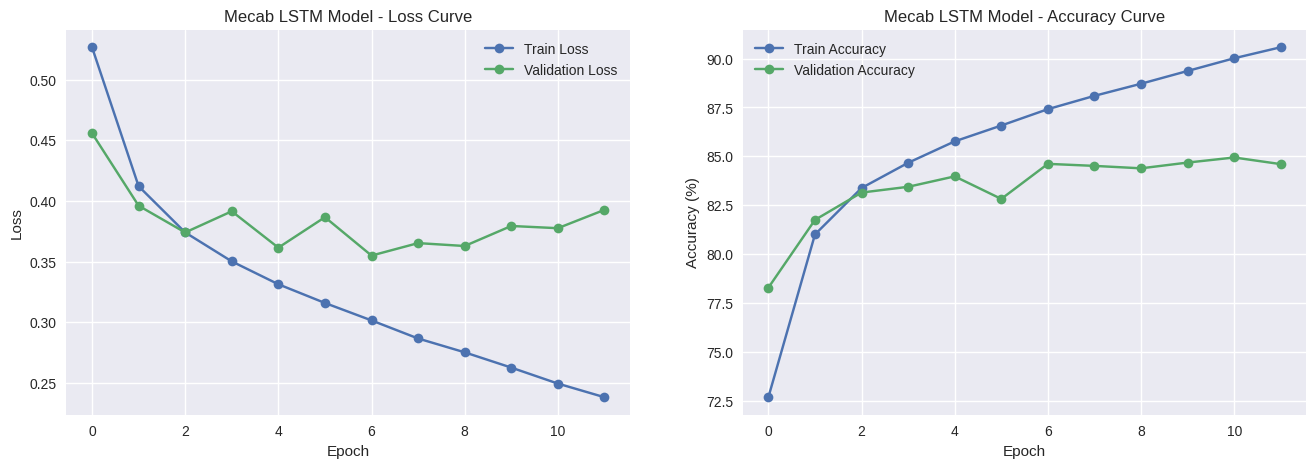

In [ ]:
from konlpy.tag import Mecab
from collections import Counter

# 1. Mecab 토크나이저 초기화
mecab = Mecab()

# 2. Mecab 실험 실행
mecab_loss, mecab_acc, mecab_history = run_experiment(
    tokenizer_name="Mecab",
    tokenizer=mecab,
    train_corpus=corpus_train,
    test_corpus=corpus_test,
    train_labels=labels_train,
    test_labels=labels_test,
    common_hparams=common_hparams
)

# 3. 결과 저장
results['Mecab'] = {'loss': mecab_loss, 'acc': mecab_acc * 100}

# 4. 그래프 그리기
plot_history(mecab_history, "Mecab LSTM Model")


--- Okt 모델 실험 시작 ---
사전 구축 시작...
사전 구축 완료. 총 단어 수: 8000
텐서 변환 시작...
텐서 변환 완료.
데이터 로더 생성 완료. Train: 3612, Val: 903, Test: 1522

--- 모델 학습 시작 ---
Epoch: 01 | Time: 0m 21s
	Train Loss: 0.525 | Train Acc: 72.72%
	 Val. Loss: 0.423 |  Val. Acc: 80.32%
Epoch: 02 | Time: 0m 21s
	Train Loss: 0.415 | Train Acc: 80.78%
	 Val. Loss: 0.397 |  Val. Acc: 81.65%
Epoch: 03 | Time: 0m 21s
	Train Loss: 0.376 | Train Acc: 83.04%
	 Val. Loss: 0.376 |  Val. Acc: 82.93%
Epoch: 04 | Time: 0m 21s
	Train Loss: 0.354 | Train Acc: 84.33%
	 Val. Loss: 0.372 |  Val. Acc: 83.09%
Epoch: 05 | Time: 0m 21s
	Train Loss: 0.335 | Train Acc: 85.50%
	 Val. Loss: 0.371 |  Val. Acc: 83.51%
Epoch: 06 | Time: 0m 22s
	Train Loss: 0.320 | Train Acc: 86.29%
	 Val. Loss: 0.375 |  Val. Acc: 83.55%
Epoch: 07 | Time: 0m 21s
	Train Loss: 0.306 | Train Acc: 87.06%
	 Val. Loss: 0.367 |  Val. Acc: 83.97%
Epoch: 08 | Time: 0m 21s
	Train Loss: 0.293 | Train Acc: 87.74%
	 Val. Loss: 0.366 |  Val. Acc: 84.00%
Epoch: 09 | Time: 0m 22s
	Train

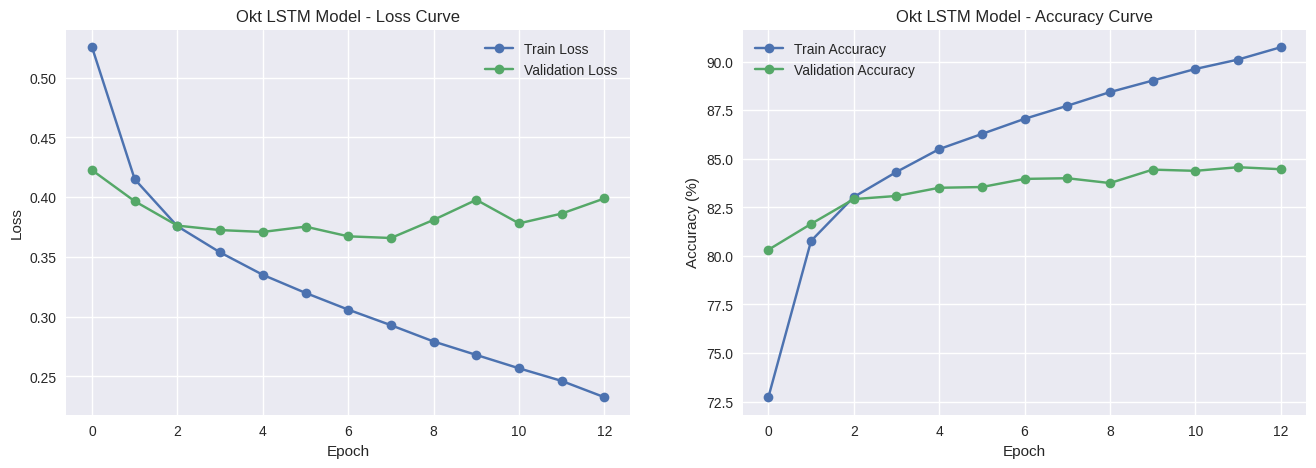

In [ ]:
from konlpy.tag import Okt

# 1. Okt 토크나이저 초기화
# stem=True: 어간 추출 (예: '하다', '하니', '하는' -> '하다')
okt = Okt()

# Okt의 morphs 메서드를 사용하기 위해 래퍼 함수를 만듭니다.
# (run_experiment 함수가 tokenizer.morphs(text)를 호출하기 때문)
class OktWrapper:
    def __init__(self):
        self.okt = Okt()

    def morphs(self, text):
        return self.okt.morphs(text, stem=True)

okt_tokenizer = OktWrapper()


# 2. Okt 실험 실행
okt_loss, okt_acc, okt_history = run_experiment(
    tokenizer_name="Okt",
    tokenizer=okt_tokenizer,
    train_corpus=corpus_train,
    test_corpus=corpus_test,
    train_labels=labels_train,
    test_labels=labels_test,
    common_hparams=common_hparams
)

# 3. 결과 저장
results['Okt'] = {'loss': okt_loss, 'acc': okt_acc * 100}

# 4. 그래프 그리기
plot_history(okt_history, "Okt LSTM Model")

# SP, Mecab, Okt 비교

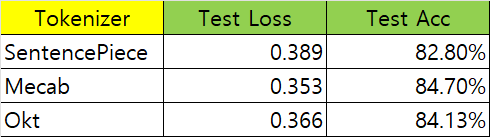  


**가설:**
- SP를 사용한 LSTM의 성능이 Mecab, Okt를 사용한 LSTM의 성능보다 좋을 것이다.

**통제 변인:**
- 전처리
- vocab_size
- 모델 & 하이퍼파라미터  
<br>

실험 결과 예상과 다르게 SP를 사용한 LSTM의 성능이 다른 두 개보다 확연히 낮았다.  
그 이유는 학습 전에 수행한 **데이터 전처리**가 문제였을 가능성이 높아 보인다.  
SP의 강점 "원본 텍스트에서 의미 있는 서브워드를 스스로 학습하는 것"이 미리 수행한 전처리 때문에 훼손되어 제대로 된 성능을 발휘하지 못 한 것 같다.  
<br>

**추후 실험 계획:**  
- 아주 기초적인 전처리(결측치 제거 등)만 수행한 후 다시 비교
- SentecnePiece의 model_type, vocab_size를 변경해가며 성능 체크해보기